# Causal Evaluation 
> Using causal analysis to compute the influence of T on Y

In [36]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

<ipython-input-36-ac09909db896>:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [37]:
#! pip install dowhy
from dowhy import CausalModel
import dowhy.datasets

In [38]:
from pathlib import Path
import csv
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import functools


pd.options.display.float_format = '{:.2f}'.format

In [39]:
from scipy import stats

In [40]:
import seaborn as sns
sns.set_theme(style="darkgrid")


In [41]:
from pandas.plotting import bootstrap_plot

In [42]:
%matplotlib inline

## Load Data Samples

In [43]:
#Load data samples
#path = '/workspaces/CodeCheckList/data/linguistic_capabilities/huggingface-CodeBERTa-small-v1_100.0_20.csv'
path = '/workspaces/CodeCheckList/data/linguistic_capabilities/microsoft-codebert-base-mlm_100.0_20.csv'
eval_df = pd.read_csv(path,index_col=0)
eval_df = eval_df.loc[eval_df['sample_id'] <= 7500]

In [44]:
eval_df.head(2)

,sample_id,ast_element,sample,masking_rate,numper_of_masked_tokens,ast_element_ocurrences,mask_jaccard,mask_sorensen_dice,mask_levenshtein,mask_random_avg_jaccard,...,mask_random_std_jaccard,mask_random_std_sorensen_dice,mask_random_std_levenshtein,n_ast_errors,ast_levels,n_whitespaces_,complexity,nloc,token_counts,n_ast_nodes
0,0,comparison_operator,def test_should_generate_secret_with_specified...,1.00,22,1,0.85,0.92,0.87,0.96,...,0.05,0.03,0.06,0,15,29,1,15,50,96
1,0,identifier,def test_should_generate_secret_with_specified...,1.00,28,9,0.87,0.93,0.88,0.91,...,0.18,0.15,0.18,0,15,29,1,15,50,96


In [45]:
eval_df.columns

Index(['sample_id', 'ast_element', 'sample', 'masking_rate',
       'numper_of_masked_tokens', 'ast_element_ocurrences', 'mask_jaccard',
       'mask_sorensen_dice', 'mask_levenshtein', 'mask_random_avg_jaccard',
       'mask_random_avg_sorensen_dice', 'mask_random_avg_levenshtein',
       'mask_random_std_jaccard', 'mask_random_std_sorensen_dice',
       'mask_random_std_levenshtein', 'n_ast_errors', 'ast_levels',
       'n_whitespaces_', 'complexity', 'nloc', 'token_counts', 'n_ast_nodes'],
      dtype='object')

In [46]:
eval_df.shape[0]

In [47]:
data_dict = {
    'ast_concept' : np.concatenate((eval_df.ast_element.values, eval_df.ast_element.values), axis=None),
    't_binary_treatment' : [True] * eval_df.shape[0] + [False] * eval_df.shape[0],
    'y_jaccard' :  np.concatenate((eval_df.mask_jaccard.values, eval_df.mask_random_avg_jaccard.values), axis=None),
    'y_levenshtein' :  np.concatenate((eval_df.mask_levenshtein.values, eval_df.mask_random_avg_levenshtein.values), axis=None),
    'y_sorensen' :  np.concatenate((eval_df.mask_sorensen_dice.values, eval_df.mask_random_avg_sorensen_dice.values), axis=None),
    'z_n_ast_errors' : np.concatenate((eval_df.n_ast_errors.values, eval_df.n_ast_errors.values), axis=None),
    'z_ast_levels' : np.concatenate((eval_df.ast_levels.values, eval_df.ast_levels.values), axis=None),
    'z_n_whitespaces' : np.concatenate((eval_df.n_whitespaces_.values, eval_df.n_whitespaces_.values), axis=None),
    'z_complexity' : np.concatenate((eval_df.complexity.values, eval_df.complexity.values), axis=None),
    'z_nloc' : np.concatenate((eval_df.nloc.values, eval_df.nloc.values), axis=None),
    'z_token_counts' : np.concatenate((eval_df.token_counts.values, eval_df.token_counts.values), axis=None),
    'z_n_ast_nodes' : np.concatenate((eval_df.n_ast_nodes.values, eval_df.n_ast_nodes.values), axis=None)
}

In [48]:
causal_data_df = pd.DataFrame(data=data_dict)

In [49]:
causal_data_df.head()

,ast_concept,t_binary_treatment,y_jaccard,y_levenshtein,y_sorensen,z_n_ast_errors,z_ast_levels,z_n_whitespaces,z_complexity,z_nloc,z_token_counts,z_n_ast_nodes
0,comparison_operator,True,0.85,0.87,0.92,0,15,29,1,15,50,96
1,identifier,True,0.87,0.88,0.93,0,15,29,1,15,50,96
2,string,True,0.36,0.34,0.53,0,15,29,1,15,50,96
3,parameters,True,0.96,0.98,0.98,0,15,29,1,15,50,96
4,comparison_operator,True,0.87,0.88,0.93,0,15,29,1,17,46,90


In [50]:
causal_data_df.describe()

,y_jaccard,y_levenshtein,y_sorensen,z_n_ast_errors,z_ast_levels,z_n_whitespaces,z_complexity,z_nloc,z_token_counts,z_n_ast_nodes
count,58154.00,58154.00,58154.00,58154.00,58154.00,58154.00,58154.00,58154.00,58154.00,58154.00
mean,0.80,0.79,0.87,0.04,11.22,30.06,2.22,9.92,71.00,113.03
std,0.19,0.20,0.15,0.26,2.74,21.89,1.92,7.77,55.29,72.70
min,0.02,0.02,0.03,0.00,4.00,2.00,1.00,1.00,5.00,8.00
25%,0.69,0.69,0.81,0.00,9.00,14.00,1.00,5.00,34.00,55.00
50%,0.85,0.85,0.91,0.00,11.00,25.00,1.00,9.00,61.00,100.00
75%,0.96,0.96,0.98,0.00,13.00,41.00,3.00,13.00,96.00,156.00
max,1.00,1.00,1.00,19.00,26.00,160.00,45.00,171.00,1130.00,425.00


In [51]:
causal_data_df[['y_jaccard','y_levenshtein','y_sorensen','t_binary_treatment']].groupby('t_binary_treatment').describe()

y_jaccard                                    y_levenshtein  \
                       count mean  std  min  25%  50%  75%  max         count   
t_binary_treatment                                                              
False               29077.00 0.84 0.16 0.09 0.75 0.88 0.97 1.00      29077.00   
True                29077.00 0.76 0.21 0.02 0.63 0.81 0.93 1.00      29077.00   

                         ...           y_sorensen                           \
                   mean  ...  75%  max      count mean  std  min  25%  50%   
t_binary_treatment       ...                                                 
False              0.83  ... 0.97 1.00   29077.00 0.89 0.12 0.17 0.85 0.93   
True               0.76  ... 0.94 1.00   29077.00 0.84 0.17 0.03 0.77 0.89   

                              
                    75%  max  
t_binary_treatment            
False              0.98 1.00  
True               0.97 1.00  

[2 rows x 24 columns]

# Density Plots Treatment vs Control

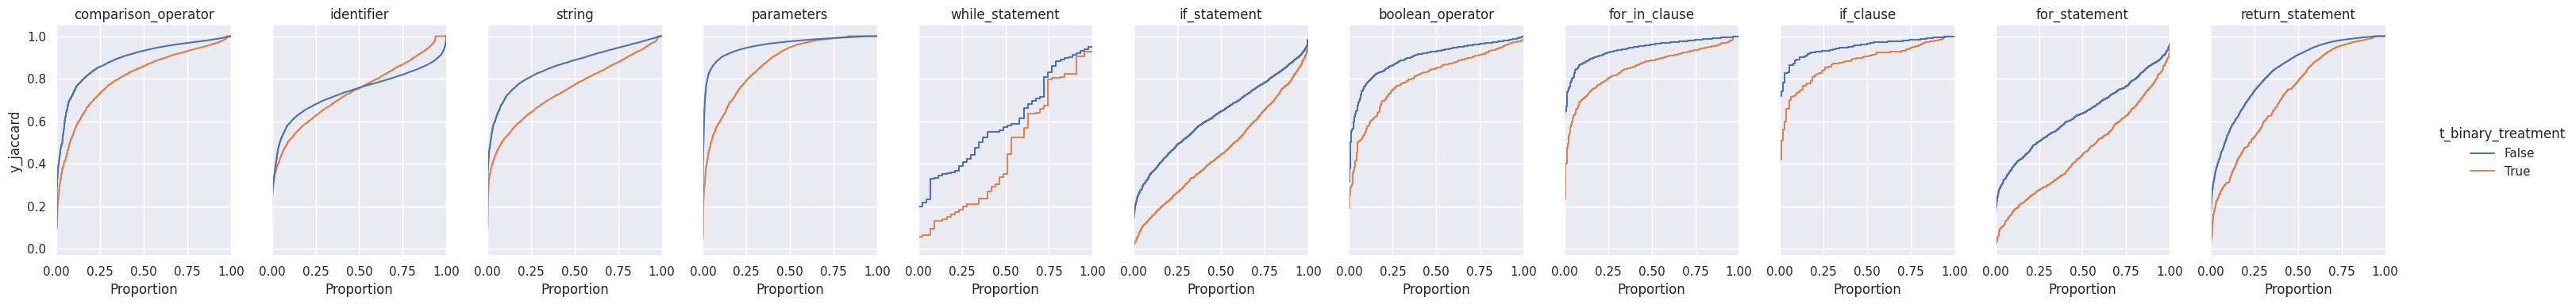

In [52]:
g = sns.displot(
    data=causal_data_df, y="y_jaccard", hue="t_binary_treatment", col="ast_concept",
    kind="ecdf", height=4, aspect=.7,
)
g.set_titles("{col_name}")

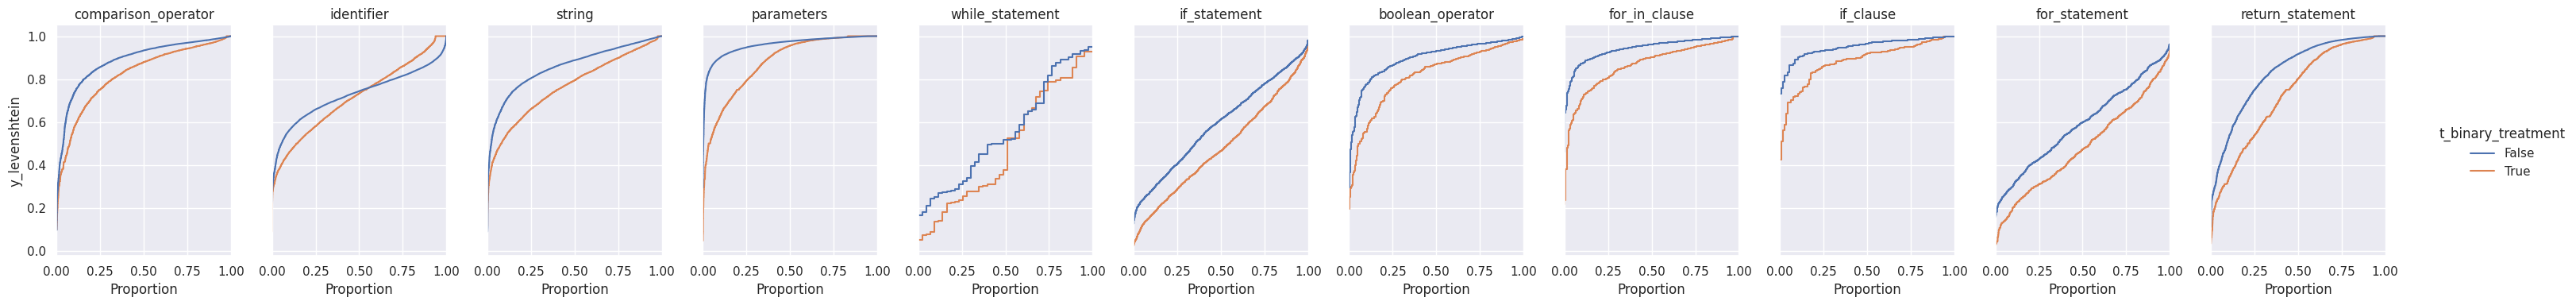

In [53]:
g = sns.displot(
    data=causal_data_df, y="y_levenshtein", hue="t_binary_treatment", col="ast_concept",
    kind="ecdf", height=4, aspect=.7,
)
g.set_titles("{col_name}")

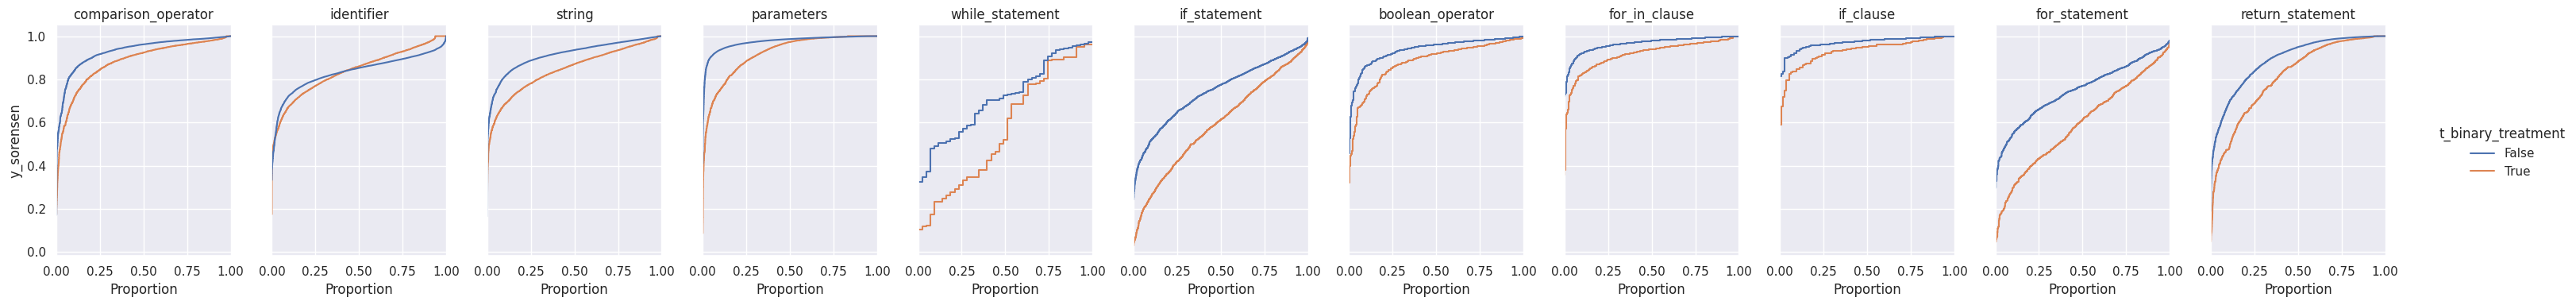

In [54]:
g = sns.displot(
    data=causal_data_df, y="y_sorensen", hue="t_binary_treatment", col="ast_concept",
    kind="ecdf", height=4, aspect=.7,
)
g.set_titles("{col_name}")

## I. Create a causal model from the data and given graph.


In [55]:
concept_set = {'boolean_operator',
 'comparison_operator',
 'for_in_clause',
 'for_statement',
 'identifier',
 'if_clause',
 'if_statement',
 'parameters',
 'return_statement',
 'string',
 'while_statement'}

In [56]:
causal_model_dict = {}

In [57]:
for concept in concept_set:
    causal_model = CausalModel(
        data = causal_data_df[causal_data_df['ast_concept']==concept],
        treatment = ['t_binary_treatment'],
        outcome = ['y_sorensen'],
        common_causes = ['z_ast_levels','z_n_whitespaces','z_complexity','z_nloc','z_token_counts','z_n_ast_nodes']
    )
    causal_model_dict[concept] = causal_model

In [58]:
causal_model_dict

{'comparison_operator': <dowhy.causal_model.CausalModel at 0x7f5ead833a00>,
 'identifier': <dowhy.causal_model.CausalModel at 0x7f5ead833a60>,
 'if_clause': <dowhy.causal_model.CausalModel at 0x7f5ead6e6490>,
 'parameters': <dowhy.causal_model.CausalModel at 0x7f5ead6f8730>,
 'for_statement': <dowhy.causal_model.CausalModel at 0x7f5ead731160>,
 'for_in_clause': <dowhy.causal_model.CausalModel at 0x7f5ead1a6af0>,
 'while_statement': <dowhy.causal_model.CausalModel at 0x7f5ead1a6a90>,
 'boolean_operator': <dowhy.causal_model.CausalModel at 0x7f5ead1a6eb0>,
 'string': <dowhy.causal_model.CausalModel at 0x7f5ead15d370>,
 'return_statement': <dowhy.causal_model.CausalModel at 0x7f5ead15d640>,
 'if_statement': <dowhy.causal_model.CausalModel at 0x7f5ead15d910>}

## I. Calculate correlations

In [59]:
def pearson(np_x, np_y):
    corr, p_val = stats.pearsonr(np_x, np_y)
    #logging.info( f"correlation:{corr} pval:{p_val}" )
    return corr

In [60]:
##LOCAL
concept_correlations = {concept: {} for concept in concept_set}
for concept in concept_set: 
    concept_data = causal_data_df[causal_data_df['ast_concept']==concept]
    concept_correlations[concept] = {'jaccard' : pearson(concept_data['t_binary_treatment'], concept_data['y_jaccard']), 
    'levenshtein' : pearson(concept_data['t_binary_treatment'], concept_data['y_levenshtein']), \
    'sorensen' : pearson(concept_data['t_binary_treatment'], concept_data['y_sorensen'])}
concept_correlations

{'comparison_operator': {'jaccard': -0.26485773343211244,
  'levenshtein': -0.20718125921016456,
  'sorensen': -0.22280906358143018},
 'identifier': {'jaccard': 0.002442289709822826,
  'levenshtein': -0.037537353266783244,
  'sorensen': 0.024377020544025033},
 'if_clause': {'jaccard': -0.39047242978642077,
  'levenshtein': -0.366691454200651,
  'sorensen': -0.33954282768727834},
 'parameters': {'jaccard': -0.3287974070831366,
  'levenshtein': -0.3230029381159275,
  'sorensen': -0.2951350620221814},
 'for_statement': {'jaccard': -0.40064970472121186,
  'levenshtein': -0.2525922199191509,
  'sorensen': -0.3949443349987694},
 'for_in_clause': {'jaccard': -0.42321059632409885,
  'levenshtein': -0.372424380771676,
  'sorensen': -0.3568647458075434},
 'while_statement': {'jaccard': -0.26779458113921784,
  'levenshtein': -0.1383905302911001,
  'sorensen': -0.297959389854712},
 'boolean_operator': {'jaccard': -0.3294879880796573,
  'levenshtein': -0.2845411306656551,
  'sorensen': -0.280936353

## II. Identify causal effect and return target estimands.


In [61]:
identified_estimand_dict = {}

In [62]:
for c_model in concept_set:
    identified_estimand = causal_model_dict[c_model].identify_effect()
    identified_estimand_dict[c_model] = identified_estimand

# III. Estimate the target estimand using a statistical method.

In [63]:
estimate_dict = {}

In [64]:
for c_model in concept_set:
    estimate = causal_model_dict[c_model].estimate_effect(
        identified_estimand_dict[c_model],
        method_name="backdoor.propensity_score_matching")
    estimate_dict[c_model] = estimate

/usr/local/lib/python3.8/dist-packages/dowhy/causal_estimators/propensity_score_estimator.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.propensity_score_column] = self.propensity_score_model.predict_proba(


/usr/local/lib/python3.8/dist-packages/dowhy/causal_estimators/propensity_score_estimator.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.propensity_score_column] = self.propensity_score_model.predict_proba(
/usr/local/lib/python3.8/dist-packages/dowhy/causal_estimators/propensity_score_estimator.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.propensity_score_column] = self.propensity_score_model.predict_proba(
/usr/local/lib/python3.8/dist-packages/dowhy/causal_estimators/p

In [65]:
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
          d                                                                   
─────────────────────(E[y_sorensen|z_complexity,z_ast_levels,z_nloc,z_n_whites
d[t_binary_treatment]                                                         

                                    
paces,z_n_ast_nodes,z_token_counts])
                                    
Estimand assumption 1, Unconfoundedness: If U→{t_binary_treatment} and U→y_sorensen then P(y_sorensen|t_binary_treatment,z_complexity,z_ast_levels,z_nloc,z_n_whitespaces,z_n_ast_nodes,z_token_counts,U) = P(y_sorensen|t_binary_treatment,z_complexity,z_ast_levels,z_nloc,z_n_whitespaces,z_n_ast_nodes,z_token_counts)

## Realized estimand
b: y_sorensen~t_binary_treatment+z_complexity+z_ast_levels+z_nloc+z_n_whitespaces+z_n_ast_nodes+z_token_counts
Target units: ate

## Estimate
Mean value: -0.

In [66]:
for c_model in concept_set:
    print( c_model + ' : ' + str(estimate_dict[c_model].value) )

comparison_operator : -0.015433677683531212
identifier : -0.03879655600356531
if_clause : -0.022077638145332812
parameters : -0.029456183120536817
for_statement : -0.08325927637266224
for_in_clause : -0.0291553600516145
while_statement : -0.07749109471408477
boolean_operator : -0.0947588490658358
string : -0.11619356684163752
return_statement : -0.07569279374418421
if_statement : -0.09547721535663088


# IV. Refute the obtained estimate using multiple robustness checks.

In [67]:
refute_results = causal_model.refute_estimate(
    identified_estimand, 
    estimate,
    method_name="random_common_cause"
    )

In [68]:
res_placebo_dict = {}

In [69]:
for c_model in concept_set:
        res_placebo = causal_model_dict[c_model].refute_estimate(
                identified_estimand_dict[c_model], 
                estimate_dict[c_model],
                method_name="placebo_treatment_refuter", 
                placebo_type="permute"
        )
        res_placebo_dict[c_model] = res_placebo

In [70]:
for c_model in concept_set:
    print( c_model + ' : ' + str(res_placebo_dict[c_model]) )

comparison_operator : Refute: Use a Placebo Treatment
Estimated effect:-0.015433677683531212
New effect:-0.001986138629217191
p value:0.98

identifier : Refute: Use a Placebo Treatment
Estimated effect:-0.03879655600356531
New effect:-0.006877211205030347
p value:0.94

if_clause : Refute: Use a Placebo Treatment
Estimated effect:-0.022077638145332812
New effect:0.001108267077373984
p value:0.94

parameters : Refute: Use a Placebo Treatment
Estimated effect:-0.029456183120536817
New effect:0.0032711351667466136
p value:0.8799999999999999

for_statement : Refute: Use a Placebo Treatment
Estimated effect:-0.08325927637266224
New effect:-0.003783192853957443
p value:0.96

for_in_clause : Refute: Use a Placebo Treatment
Estimated effect:-0.0291553600516145
New effect:0.0002864617739949336
p value:0.98

while_statement : Refute: Use a Placebo Treatment
Estimated effect:-0.07749109471408477
New effect:0.011372831973058639
p value:0.9199999999999999

boolean_operator : Refute: Use a Placebo Tr